In [2]:


import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
from datetime import datetime
import os
from thermal_lib import *
from tqdm import tqdm

def plot_avg(var, isDay, draw_sub=True, draw_sem = True, draw_zero = False, ax=None, color='b'):

    if ax is None:
        fig, ax = plt.subplots(figsize=(6,4))

    if draw_zero:
        ax.axhline(0,color='k',linestyle='--')

    if draw_sub:
        for c in var.columns:
            ax.plot(var.index, var[c],color,alpha=.1)

    avg = var.mean(axis=1) 

    if draw_sem:
        sem = var.sem(axis=1) 
        ax.fill_between(var.index, avg+sem, avg-sem, alpha=.3, color=color,edgecolor='none')

    ax.plot(var.index, avg,color,alpha=1)
    xlims = [var.index[0], var.index[-1]]
    ax.set_xlim(xlims)
    ylims = ax.get_ylim()
    ax.fill_between(var.index, y1=ylims[0], y2=ylims[1], where=isDay<1,alpha=.2, color='gray',edgecolor='none')
    ax.set_ylim(ylims)
    #ax.set_xlabel('Time [Hours]')
    
def plot_raw(data=None, y=None, x=None, isDay=None, ax=None, hzero=True):
    
    if ax is None:
        fig,ax = plt.subplots(figsize=(8,3))

    if x is None:
        x = data.index
    
    if hzero:
        ax.axhline(0,color='k',linestyle='--')
    
    ax.plot(x, data[y] )
    ax.set_ylim([data[y].min()*1.1, data[y].max()*1.1 ])
    ylims = ax.get_ylim()
    ax.fill_between(x, where=data['isDay']==0, 
                    y1=ylims[0], 
                    y2=ylims[1], 
                    color='gray', alpha=.2, edgecolor='None' )

    ax.set_xlim([x[0], x[-1]])
    return ax

    
%matplotlib notebook

In [3]:

#pth = r'D:\thermography\cdkl5_thermal_behaviour_group1\unico'
pth = None
sub = Subjects(pth)
print(sub)

Number of Subjects: 16

0 -> ID: WT_74 RECs: 3
1 -> ID: WT_91 RECs: 3
2 -> ID: WT_97 RECs: 3
3 -> ID: KO_70 RECs: 3
4 -> ID: KO_72 RECs: 3
5 -> ID: KO_99 RECs: 3
6 -> ID: WT_86 RECs: 3
7 -> ID: WT_83 RECs: 3
8 -> ID: KO_87 RECs: 3
9 -> ID: WT_79 RECs: 3
10 -> ID: KO_69 RECs: 3
11 -> ID: KO_1021 RECs: 3
12 -> ID: KO_77 RECs: 3
13 -> ID: WT_71 RECs: 3
14 -> ID: WT_81 RECs: 3
15 -> ID: KO_75 RECs: 3



In [4]:
data_min = sub.get_data(1)

<IPython.core.display.Javascript object>


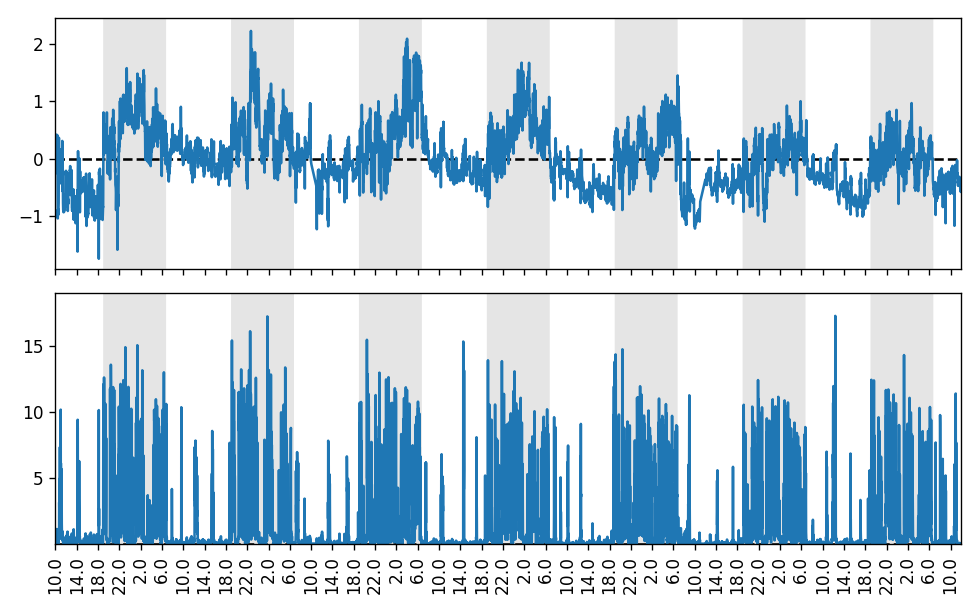

In [5]:


fig,ax = plt.subplots(2,1,figsize=(8,5),sharex=True )
plot_raw(data=data_min, y='temp_rt_corrected',ax=ax[0]) 
ax[0].set_xticks(np.array(range(0,data_min.index[-1], 240)), data_min.loc[range(0,data_min.index[-1], 240),'hour'], rotation=90 )
plot_raw(data=data_min, y='distance',ax=ax[1]) 
ax[1].set_xticks(np.array(range(0,data_min.index[-1], 240)), data_min.loc[range(0,data_min.index[-1], 240),'hour'], rotation=90 )
plt.tight_layout()  





In [27]:

days = dict()
temperature_each_day = dict()
for d in range( data_min['day'].unique().max()-1 ):
    i = 1440 * d
    days[d] = data_min.loc[0+i:1439+i]
    temperature_each_day[d] = days[d]['temp_rt_corrected'].reset_index(drop=True)

temperature_each_day = pd.DataFrame.from_dict(temperature_each_day)



<IPython.core.display.Javascript object>


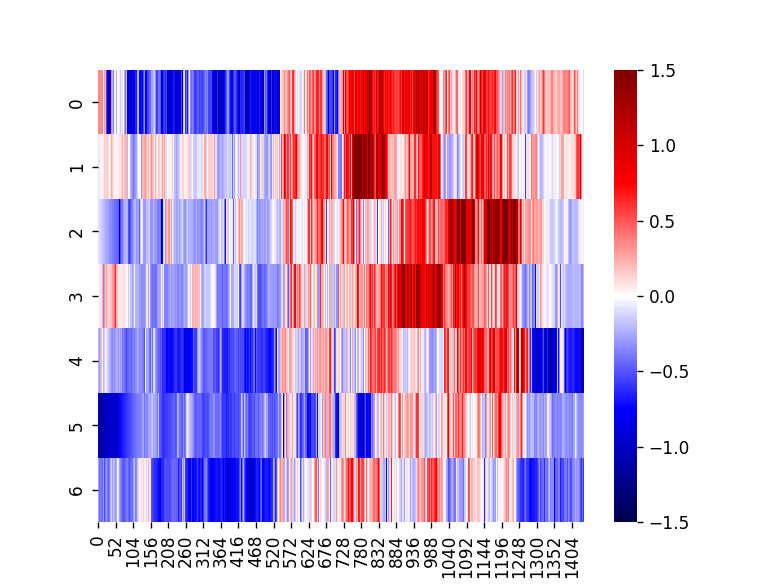

<AxesSubplot:>

In [52]:
import seaborn as sns

fig,ax = plt.subplots()
#ax.axhline(0,color='k',linestyle='--')
sns.heatmap( temperature_each_day.T, cmap='seismic', vmin=-1.5, vmax=1.5) #, color='b', alpha=.2)
#ax.plot( temperature_each_day.mean(axis=1), color='b', alpha=1 )



<IPython.core.display.Javascript object>


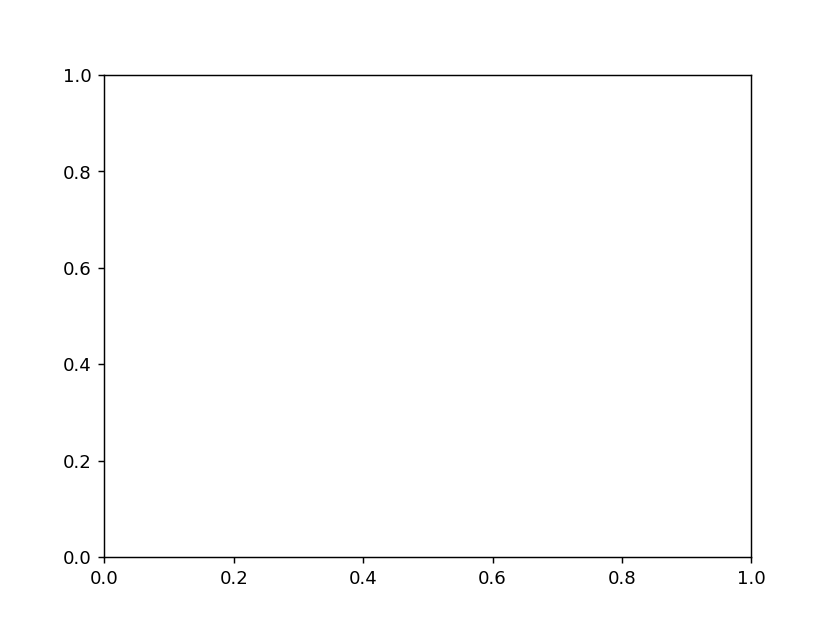

ValueError: setting an array element with a sequence.

In [24]:
fig,ax = plt.subplots()
ax.plot(temp['temp_med_delta'] )
#ax.plot(mins.diff() )

<IPython.core.display.Javascript object>


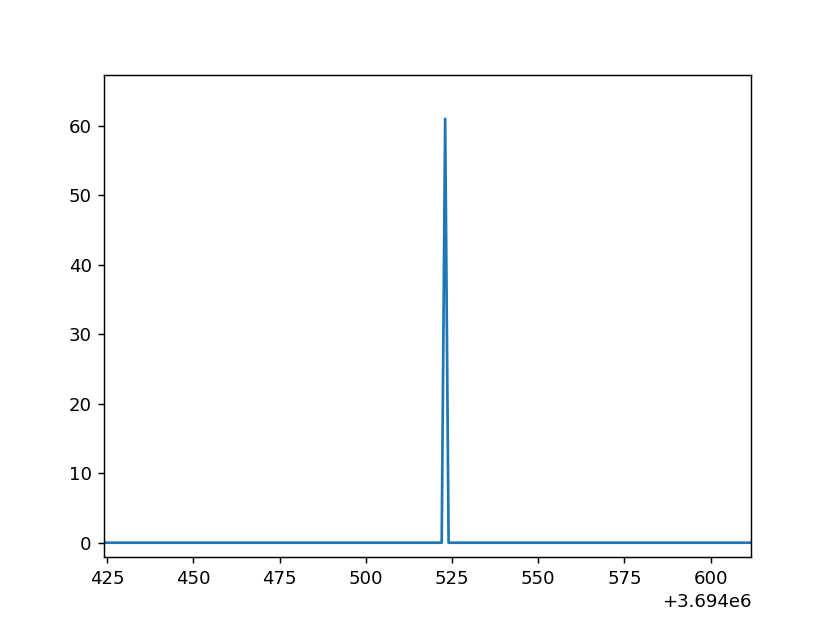

In [4]:

fig,ax = plt.subplots()
mins = data['minute']-600
ax.plot(mins.diff() ) #data['temp_med_delta'])
ax.plot(data['isDay']*600 )

In [4]:

# motion & temperature
motion = dict()
isDay = list()
temperature = dict()
for info,rec in tqdm( sub.iter_data_day(), total=len(sub) ):
    motion[(info['geno'], info['id'])] = rec['distance']
    temperature[(info['geno'], info['id'])] = rec['temp_rt_diff']
    isDay.append(rec['isDay'])
    #print(info['geno'], info['id'],len(rec['temp_rt_diff']),len(rec['isDay']))
    
isDay = pd.concat(isDay,axis=1).mean(axis=1)
motion = pd.DataFrame.from_dict(motion)
motion.index = motion.index/60
temperature = pd.DataFrame.from_dict(temperature,)
temperature.index = temperature.index/60



100%|██████████| 8/8 [00:00<00:00, 40.93it/s]


<IPython.core.display.Javascript object>


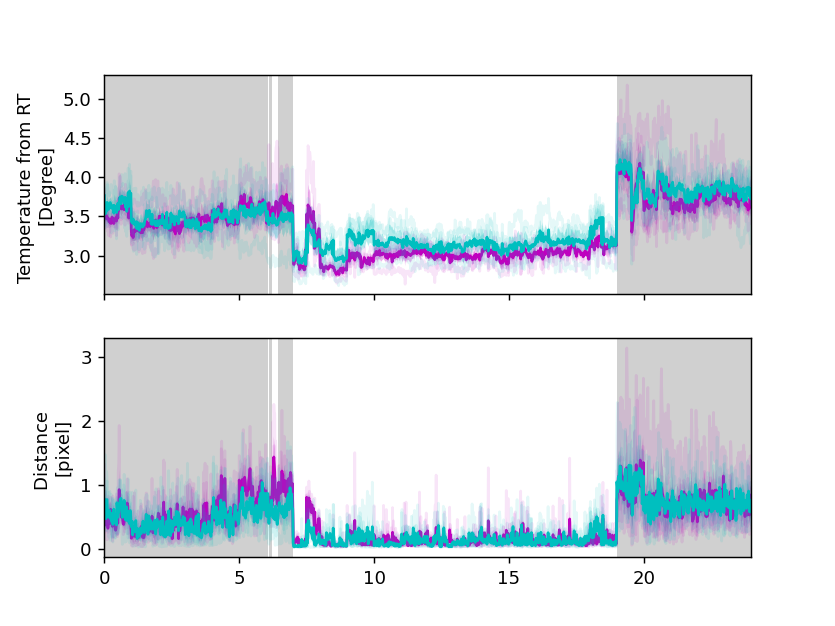

Text(0, 0.5, 'Distance \n[pixel]')

In [5]:
fig,ax = plt.subplots(2,1,sharex=True) 
plot_avg(temperature.xs('KO',level=0,axis=1), isDay,color='m',ax=ax[0])
plot_avg(temperature.xs('WT',level=0,axis=1), isDay,color='c',ax=ax[0])
ax[0].set_ylabel('Temperature from RT \n[Degree]')

plot_avg(motion.xs('KO',level=0,axis=1), isDay,color='m', ax=ax[1])
plot_avg(motion.xs('WT',level=0,axis=1), isDay,color='c', ax=ax[1])
ax[1].set_ylabel('Distance \n[pixel]')